# Bike Sharing Regression Analysis

Recreating the analysis from Chapter 5 of Christoph Molnar's *Interpretable Machine Learning*.

We use the [Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) (daily aggregation, 731 rows) to predict daily bike rental counts (`cnt`) using weather and calendar features, then explore feature dependence.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.metrics import normalized_mutual_info_score

sns.set_theme(style="whitegrid")
print("Imports OK")

Imports OK


## Load & Inspect Raw Data

In [2]:
raw = pd.read_csv("bike_sharing_dataset/day.csv")
print(f"Shape: {raw.shape}")
display(raw.head())
raw.dtypes

Shape: (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


instant         int64
dteday            str
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## Data Processing

Following Molnar's methodology:
- Denormalize `temp`, `hum`, `windspeed` to real-world units
- Map `season` and `weathersit` to readable categories
- Create `cnt_2d_bfr` (bike count from 2 days prior) as a lag feature
- Drop first 2 rows (no lag available) and rows with `hum == 0` (measurement error)

Target: **728 rows, 9 columns**

In [3]:
df = raw.copy()

# Denormalize to real-world units
df["temp"] = df["temp"] * 41          # degrees Celsius
df["hum"] = df["hum"] * 100           # percent
df["windspeed"] = df["windspeed"] * 67 # km/h

# Map season: 1=spring, 2=summer, 3=fall, 4=winter
season_map = {1: "spring", 2: "summer", 3: "fall", 4: "winter"}
df["season"] = df["season"].map(season_map).astype("category")

# Map weather situation: 1=Good, 2=Misty, 3/4=Bad
weather_map = {1: "Good", 2: "Misty", 3: "Bad", 4: "Bad"}
df["weather"] = df["weathersit"].map(weather_map).astype("category")

# Rename workingday -> workday
df = df.rename(columns={"workingday": "workday"})

# Lag feature: bike count from 2 days prior
df["cnt_2d_bfr"] = df["cnt"].shift(2)

# Drop first 2 rows (no lag) and rows where hum == 0 (measurement error)
df = df.iloc[2:].copy()
df = df[df["hum"] != 0].copy()

# Select final columns
df = df[["cnt", "season", "holiday", "workday", "weather", "temp", "hum", "windspeed", "cnt_2d_bfr"]]
df = df.reset_index(drop=True)

print(f"Processed shape: {df.shape}")
assert df.shape == (728, 9), f"Expected (728, 9), got {df.shape}"
display(df.head(10))
df.dtypes

Processed shape: (728, 9)


,cnt,season,holiday,workday,weather,temp,hum,windspeed,cnt_2d_bfr
0,1349,spring,0,1,Good,8.050924,43.7273,16.636703,985.0
1,1562,spring,0,1,Good,8.200000,59.0435,10.739832,801.0
2,1600,spring,0,1,Good,9.305237,43.6957,12.522300,1349.0
3,1606,spring,0,1,Good,8.378268,51.8261,6.000868,1562.0
4,1510,spring,0,1,Misty,8.057402,49.8696,11.304642,1600.0
5,959,spring,0,0,Misty,6.765000,53.5833,17.875868,1606.0
6,822,spring,0,0,Good,5.671653,43.4167,24.250650,1510.0
7,1321,spring,0,1,Good,6.184153,48.2917,14.958889,959.0
8,1263,spring,0,1,Misty,6.932731,68.6364,8.182844,822.0
9,1162,spring,0,1,Good,7.081807,59.9545,20.410009,1321.0


cnt              int64
season        category
holiday          int64
workday          int64
weather       category
temp           float64
hum            float64
windspeed      float64
cnt_2d_bfr     float64
dtype: object

## Train/Test Split

Temporal split: first 2/3 of days for training, last 1/3 for testing (no shuffling — respects time ordering).

In [4]:
from sklearn.model_selection import train_test_split

target = "cnt"
features = [c for c in df.columns if c != target]

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=1/3, random_state=42)

print(f"Train: {X_train.shape[0]} rows, Test: {X_test.shape[0]} rows")
print(f"{X_train.head()}")
print(f"Features: {features}")

Train: 485 rows, Test: 243 rows
     season  holiday  workday weather       temp      hum  windspeed  \
73   spring        0        1    Good  22.140000  52.5217  15.478139   
167  summer        0        1   Misty  26.035000  74.6250  10.416825   
431  spring        0        0    Good  11.787500  35.0417  15.125250   
636  winter        0        1   Misty  21.354153  64.9167   6.083881   
66   spring        0        1   Misty  12.977402  64.9565  15.608990   

     cnt_2d_bfr  
73       2192.0  
167      5119.0  
431      5382.0  
636      8555.0  
66       1891.0  
Features: ['season', 'holiday', 'workday', 'weather', 'temp', 'hum', 'windspeed', 'cnt_2d_bfr']


## Model Training & Evaluation

We train four models from Molnar's Table 5.1 and compare RMSE and MAE on the held-out test set.

A `ColumnTransformer` one-hot encodes the categorical features (`season`, `weather`) and passes numerical features through. For SVM, we additionally scale all features (SVMs are sensitive to feature magnitude).

In [5]:
from sklearn.compose import TransformedTargetRegressor

cat_features = ["season", "weather"]
num_features = [f for f in features if f not in cat_features]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_features),
    ("num", "passthrough", num_features),
])

# SVM needs scaling on top of encoding
svr_preprocessor = Pipeline([
    ("encode", preprocessor),
    ("scale", StandardScaler()),
])

# SVR with scaled target — SVR works best when both features AND target are standardized
svr_pipe = Pipeline([("pre", svr_preprocessor), ("model", SVR(kernel="rbf"))])
svr_model = TransformedTargetRegressor(regressor=svr_pipe, transformer=StandardScaler())

models = {
    "Linear Regression": Pipeline([("pre", preprocessor), ("model", LinearRegression())]),
    "Decision Tree":     Pipeline([("pre", preprocessor), ("model", DecisionTreeRegressor(random_state=42))]),
    "Random Forest":     Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(n_estimators=100, random_state=42))]),
    "SVM":               svr_model,
}

results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    results.append({"Model": name, "RMSE": round(rmse, 1), "MAE": round(mae, 1)})

results_df = pd.DataFrame(results)
display(results_df)

,Model,RMSE,MAE
0,Linear Regression,903.6,706.2
1,Decision Tree,1232.7,913.2
2,Random Forest,835.3,609.4
3,SVM,767.6,576.4


## Pearson Correlation (Numerical Features)

Pearson correlation measures **linear** association between numerical feature pairs.

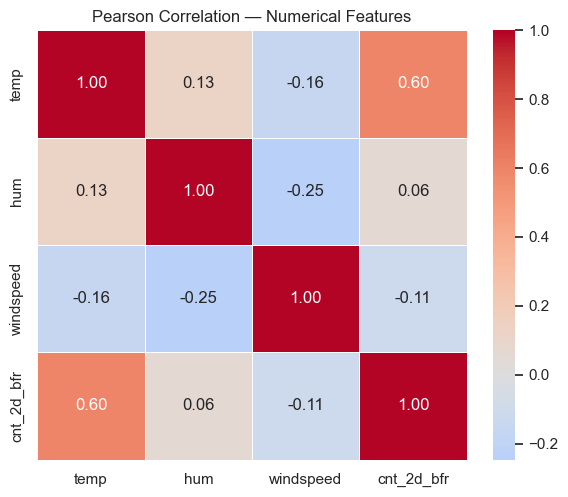

In [6]:
num_cols = ["temp", "hum", "windspeed", "cnt_2d_bfr"]
corr = df[num_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title("Pearson Correlation — Numerical Features")
plt.tight_layout()
plt.show()

## Normalized Mutual Information (NMI)

NMI captures **any** dependence (not just linear) between features — but it requires discrete labels. Numerical features must be **binned** before computing NMI.

### Your turn: binning strategy

The function `bin_numerical` below needs your implementation. This is a meaningful design choice:

- **Equal-width bins** (`pd.cut`): splits the range into equal intervals. Simple, but skewed data can leave most values in one bin.
- **Quantile bins** (`pd.qcut`): each bin gets ~equal number of observations. Better for skewed distributions, but bin edges can be unintuitive.
- **Number of bins**: more bins = finer granularity but noisier NMI estimates; fewer bins = more stable but can miss patterns. Molnar uses a moderate number (4-5 is common).

Implement `bin_numerical(series, n_bins)` in the cell below — it should return integer bin labels (0 to n_bins-1).

In [7]:
def bin_numerical(series: pd.Series, n_bins: int = 5) -> pd.Series:
    """Bin a numerical series into discrete labels for NMI computation.

    Args:
        series: Numerical feature values.
        n_bins: Number of bins to create.

    Returns:
        Integer bin labels (0 to n_bins-1).
    """
    # TODO: Implement your binning strategy here.
    #   Option A (equal-width):  pd.cut(series, bins=n_bins, labels=False)
    #   Option B (quantile):     pd.qcut(series, q=n_bins, labels=False, duplicates="drop")
    # Consider which handles skewed distributions better.
    return pd.qcut(series, q=n_bins, labels=False, duplicates="drop")


# --- NMI computation (runs once you implement bin_numerical) ---

def get_discrete(col: str) -> np.ndarray:
    """Return discrete labels for a column — bin if numerical, use codes if categorical."""
    if df[col].dtype.name == "category":
        return df[col].cat.codes.values
    return bin_numerical(df[col]).values

nmi_pairs = [
    ("temp", "season"),
    ("cnt_2d_bfr", "temp"),
    ("weather", "season"),
    ("weather", "hum"),
    ("temp", "hum"),
    ("windspeed", "weather"),
]

nmi_rows = []
for v1, v2 in nmi_pairs:
    score = normalized_mutual_info_score(get_discrete(v1), get_discrete(v2))
    nmi_rows.append({"Variable 1": v1, "Variable 2": v2, "NMI": round(score, 3)})

nmi_df = pd.DataFrame(nmi_rows)
display(nmi_df)

,Variable 1,Variable 2,NMI
0,temp,season,0.348
1,cnt_2d_bfr,temp,0.158
2,weather,season,0.009
3,weather,hum,0.181
4,temp,hum,0.033
5,windspeed,weather,0.010


## Pairwise Dependence Plots

- **Scatter plots** for numerical × numerical pairs
- **Box plots** for categorical × numerical pairs

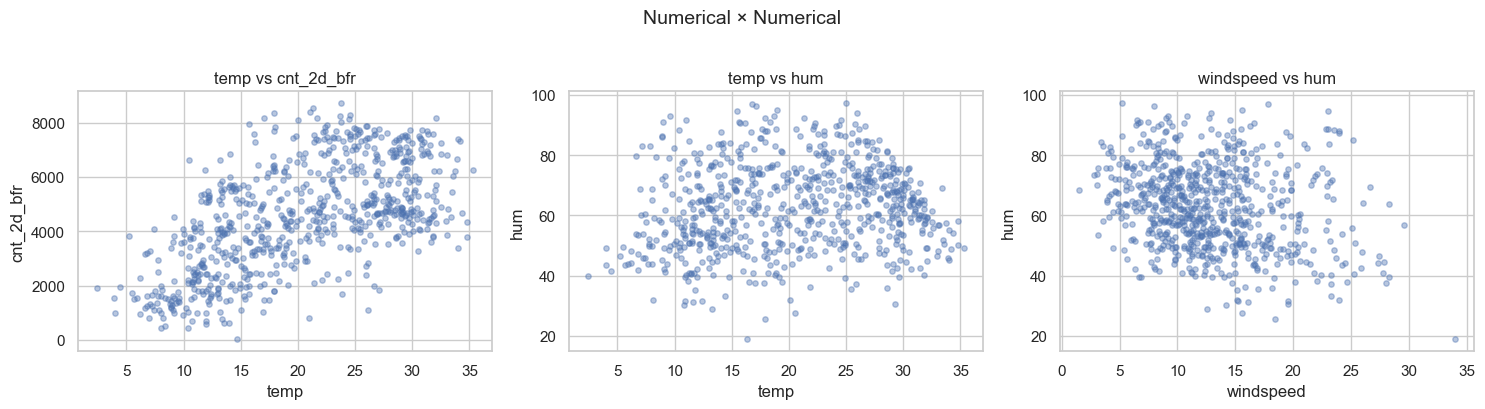

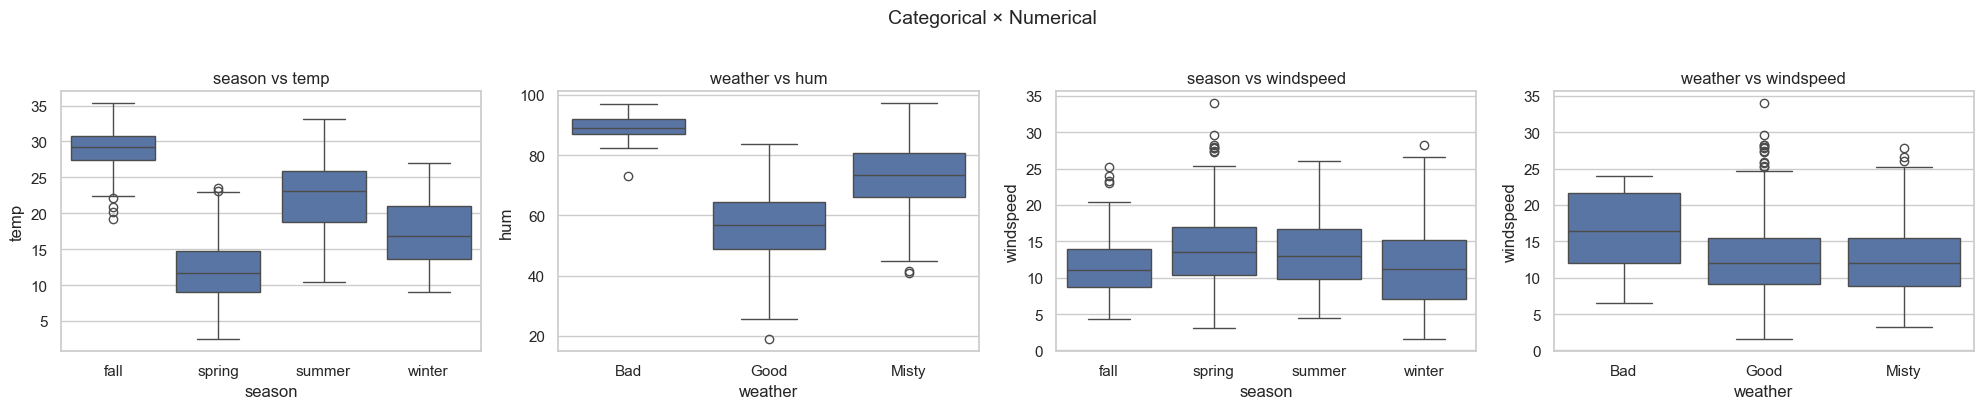

In [8]:
# --- Numerical x Numerical: scatter plots ---
num_pairs = [
    ("temp", "cnt_2d_bfr"),
    ("temp", "hum"),
    ("windspeed", "hum"),
]

fig, axes = plt.subplots(1, len(num_pairs), figsize=(5 * len(num_pairs), 4))
for ax, (x, y) in zip(axes, num_pairs):
    ax.scatter(df[x], df[y], alpha=0.4, s=15)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f"{x} vs {y}")
plt.suptitle("Numerical × Numerical", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# --- Categorical x Numerical: box plots ---
cat_num_pairs = [
    ("season", "temp"),
    ("weather", "hum"),
    ("season", "windspeed"),
    ("weather", "windspeed"),
]

fig, axes = plt.subplots(1, len(cat_num_pairs), figsize=(5 * len(cat_num_pairs), 4))
for ax, (cat, num) in zip(axes, cat_num_pairs):
    sns.boxplot(data=df, x=cat, y=num, ax=ax)
    ax.set_title(f"{cat} vs {num}")
plt.suptitle("Categorical × Numerical", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()